In [2]:
%matplotlib inline
from ggplot import *
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

import sklearn.linear_model as sklin
import sklearn.metrics as skmet
import sklearn.cross_validation as skcv
import sklearn.grid_search as skgs
import sklearn.preprocessing as skpr
from sklearn.linear_model import Ridge
import pandas as pd
#from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model.stochastic_gradient import SGDRegressor

In [3]:
train = np.loadtxt(open("/Users/Anuar_The_Great/Desktop/Project/train.csv", "rb"), 
                    delimiter=",", skiprows=1)
test0 = np.loadtxt(open("/Users/Anuar_The_Great/Desktop/Project/test.csv", "rb"), 
                    delimiter=",", skiprows=1)

# Getting rid of the outlier
train[207,:]
train = np.delete(train, 207, 0)

870

In [4]:
def get_features(data):
    return np.hstack((data, data*data))    # You can also do log and interaction terms!


X = train[:, 2:17]
print(X.shape)
test = test0[:, 1:16]
print('test.shape', test.shape)
#X = more_terms(X)
#X = np.hstack((X, np.ones((X.shape[0], 1))))
#test = np.hstack((test, np.ones((test.shape[0], 1))))

Y = train[:, 1]

#print(len(feature_names))
#X = skpr.scale(X)
#test = skpr.scale(test)

poly = skpr.PolynomialFeatures(degree=3, interaction_only=False)
X = poly.fit_transform(X) 
poly = skpr.PolynomialFeatures(degree=3, interaction_only=False)
test = poly.fit_transform(test)

print('X.shape', X.shape)
print('Y.shape', Y.shape)
print('test.shape', test.shape)

(899, 15)
test.shape (2000, 15)
X.shape (899, 816)
Y.shape (899,)
test.shape (2000, 816)


(array([  12.,    7.,   18.,   59.,   92.,  116.,  139.,  114.,  115.,
          92.,   59.,   38.,   26.,    4.,    8.]),
 array([-1.84155112, -1.45539467, -1.06923821, -0.68308176, -0.29692531,
         0.08923115,  0.4753876 ,  0.86154406,  1.24770051,  1.63385696,
         2.02001342,  2.40616987,  2.79232632,  3.17848278,  3.56463923,
         3.95079569]),
 <a list of 15 Patch objects>)

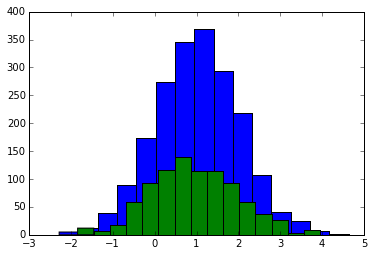

In [660]:
#plt.hist(Y, bins=20)
plt.hist(test[:,6], bins=15)
plt.hist(X[:,6], bins=15)


In [6]:
def score(gtruth, pred):
    diff = gtruth - pred
    return -np.sqrt(np.mean(np.square(diff)))
scorefun = skmet.make_scorer(score)
neg_scorefun = skmet.make_scorer(lambda x, y: -score(x, y))

In [7]:
# Solving Normal Equation
beta = np.linalg.solve(X.T.dot(X) + 20*np.eye(X.shape[1]), X.T.dot(Y))

# Training Error
score(Y, beta.dot(X.T))

X_train, X_test, y_train, y_test = skcv.train_test_split(
    X, Y, test_size=0.3, random_state=0)
beta = np.linalg.solve(X_train.T.dot(X_train) + 125*np.eye(X_train.shape[1]), X_train.T.dot(y_train))
print(score(y_test, X_test.dot(beta)))
X_train, X_test, y_train, y_test = skcv.train_test_split(
    X, Y, test_size=0.3, random_state=3)
print(score(y_test, X_test.dot(beta)))

-18.6073967708
-13.0829960186


In [12]:
#regressor_ridge = Ridge()

param_grid = {'alpha': [1, 5, 10, 30, 50, 75, 100, 150, 200, 300, 750, 1000, 3000]}
param_grid = {'alpha': np.linspace(10,500, 12),
             'l1_ratio': [ 0.3, 0.5, 0.7],
             'power_t': [0.1, 0.3, 0.6, 1],
             'epsilon': [ 0.1, 1, 10]}

#param_grid = {'alpha': [5000, 7500, 10000, 50000, 100000, 500000, 1000000]}

sgd = SGDRegressor(average=False, eta0=0.01,
       fit_intercept=True, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet',
       random_state=None, shuffle=True, verbose=1, warm_start=False)

In [13]:
grid_search = skgs.GridSearchCV(sgd, param_grid, scoring=scorefun, cv=5)
grid_search.fit(X, Y)

-- Epoch 1
Norm: 1442517257996.62, NNZs: 816, Bias: -83568634589.967987, T: 719, Avg. loss: 166511760709611993882951680.000000
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1242470222765.08, NNZs: 816, Bias: -77236906703.436859, T: 1438, Avg. loss: 147284467568947150341537792.000000
Total training time: 0.02 seconds.
-- Epoch 3
Norm: 1368862086234.15, NNZs: 816, Bias: -109550051974.164474, T: 2157, Avg. loss: 136114247635864560187998208.000000
Total training time: 0.03 seconds.
-- Epoch 4
Norm: 1025791597953.20, NNZs: 816, Bias: -167814139853.739502, T: 2876, Avg. loss: 130034150129276130160541696.000000
Total training time: 0.04 seconds.
-- Epoch 5
Norm: 1067171244650.89, NNZs: 816, Bias: -171429080903.732605, T: 3595, Avg. loss: 125700490640884682998153216.000000
Total training time: 0.05 seconds.
-- Epoch 1
Norm: 1285602009568.21, NNZs: 816, Bias: 22930893263.156754, T: 719, Avg. loss: 155430881901944921099599872.000000
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 12484

KeyboardInterrupt: 

In [11]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.grid_scores_)

SGDRegressor(alpha=143.63636363636363, average=False, epsilon=1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.7, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=1,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
-49.3627854097
[mean: -11555743628731.87500, std: 1966047021842.49121, params: {'alpha': 10.0, 'power_t': 0.1, 'l1_ratio': 0.3, 'epsilon': 0.1}, mean: -2900440596460.37207, std: 306732919411.45886, params: {'alpha': 10.0, 'power_t': 0.3, 'l1_ratio': 0.3, 'epsilon': 0.1}, mean: -18709027425.48613, std: 4586088894.89169, params: {'alpha': 10.0, 'power_t': 0.6, 'l1_ratio': 0.3, 'epsilon': 0.1}, mean: -1100839.04430, std: 916501.74160, params: {'alpha': 10.0, 'power_t': 1, 'l1_ratio': 0.3, 'epsilon': 0.1}, mean: -13788089162574.41992, std: 2679359183187.75000, params: {'alpha': 10.0, 'power_t': 0.1, 'l1_ratio': 0.5, 'epsilon': 0.1}, mean: -2865762320946.58008, std: 394654548593.80487, params: {'alpha': 10.0, '

In [509]:
# Iteration through the list of alphas and generation of accuracy from the testing set
alpha_list = [1, 5, 10, 30, 50, 75, 100, 150, 200, 300, 750, 1000, 3000]
scores_df = pd.DataFrame(alpha_list, columns=['alphas'])
scores_df['values'] = 1
for i, alpha_num in enumerate(alpha_list):
    lr = Ridge(alpha=alpha_num, tol=0.001, solver='auto')
    #lr.fit(X, Y)
    #Xtrain, Xtest, Ytrain, Ytest = skcv.train_test_split(X, Y, train_size=0.70)
    scores = skcv.cross_val_score(lr, X, Y, scoring=scorefun, cv=10)
    fn_score = np.mean(scores)
    print(fn_score)
    scores_df.iloc[i, 1] = fn_score
    


32.104764922
31.5408681897
31.0087913208
29.7959211623
29.1762850838
28.7031597255
28.3851103564
27.9664647564
27.6934389404
27.3513602572
26.8900999851
26.8946147621
28.1223162366


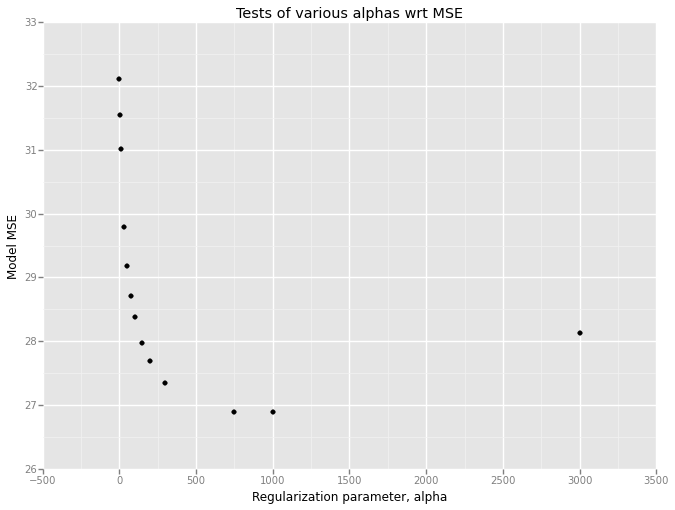

<ggplot: (288112461)>

In [510]:
ggplot(scores_df, aes(x='alphas', y='values')) + geom_point() +\
        labs('Regularization parameter, alpha', 'Model MSE', 'Tests of various alphas wrt MSE')

In [437]:
def train_error(X, Y, alpha):
    lr_test = Ridge(alpha=alpha)
    lr_test.fit(X, Y)
    pred = lr_test.predict(X)
    submission = lr_test.predict(test)
    return score(Y, pred)
print(train_error(X, Y, 50))


score(Y, beta.dot(X.T))

37.1823079104


ValueError: shapes (77,) and (16,900) not aligned: 77 (dim 0) != 16 (dim 0)

In [ ]:
scores = skcv.cross_val_score(Ridge(alpha=30), X, Y, scoring=scorefun, cv=5)
fn_score = np.mean(scores)
print(fn_score)

In [431]:
# Fit regression model
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(X, Y).predict(X)
y_lin = svr_lin.fit(X, Y).predict(X)
y_poly = svr_poly.fit(X, Y).predict(X)

# Training error
print(score(Y, y_rbf))
print(score(Y, y_lin))
print(score(Y, y_poly))


0.100008530948
33.0484876797
27.2561361627


In [381]:
# CV error
scores = skcv.cross_val_score(svr_rbf, X, Y, scoring=scorefun, cv=20)
print(np.mean(scores))
scores = skcv.cross_val_score(svr_lin, X, Y, scoring=scorefun, cv=20)
print(np.mean(scores))
scores = skcv.cross_val_score(svr_poly, X, Y, scoring=scorefun, cv=20)
print(np.mean(scores))

45.6313552457
33.8621522178
58.5796997601


In [410]:
# Iteration through the list of alphas and generation of accuracy from the testing set
alpha_list = [ 0.01, 0.1, 0.5, 1, 5, 10, 30, 50, 75, 100, 135, 150, 200, 300, 100000, 1000000, 10000000]
scores_df = pd.DataFrame(alpha_list, columns=['alphas'])
scores_df['values'] = 1
for i, alpha_num in enumerate(alpha_list):
    sgd = SGDRegressor(alpha=alpha_num, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.25, learning_rate='invscaling',
       loss='squared_loss', n_iter=50, penalty='elasticnet', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

    #lr.fit(X, Y)
    #Xtrain, Xtest, Ytrain, Ytest = skcv.train_test_split(X, Y, train_size=0.70)
    scores = skcv.cross_val_score(sgd, X, Y, scoring=scorefun, cv=50)
    fn_score = np.mean(scores)
    print(fn_score)
    scores_df.iloc[i, 1] = fn_score
    

6.11485941952e+12
5.8289734934e+12
6.09019670652e+12
6.04276884143e+12
4.89985129425e+12
5.43352212857e+12
4.86155528698e+12
4.13082039684e+12
3.73465244318e+12
3.36498592909e+12
3.2363210805e+12
3.10785588741e+12
2.56670016102e+12
1.97020352099e+12
52.0622731684
52.0713955546
52.0701111235


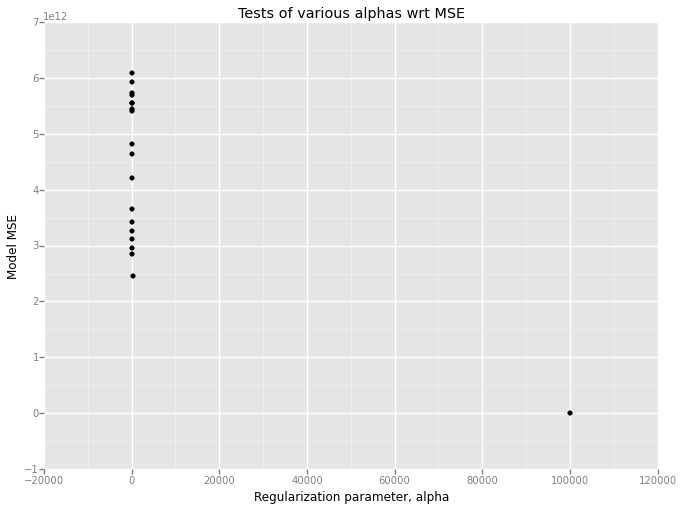

<ggplot: (281240737)>

In [409]:
ggplot(scores_df, aes(x='alphas', y='values')) + geom_point() +\
        labs('Regularization parameter, alpha', 'Model MSE', 'Tests of various alphas wrt MSE')

In [439]:
lr_test = Ridge(alpha=40)
lr_test.fit(X, Y)
submission = lr_test.predict(test)
np.savetxt('first.csv', submission)

In [789]:
best = grid_search.best_estimator_
best.fit(X, Y)
submission = test.dot(beta)
np.savetxt('last.csv', submission)

In [689]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor()
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 8],
             'leaf_size': [2, 5, 10, 20, 30, 50, 70],
             'algorithm': ['ball_tree', 'brute', 'kd_tree'],
             'weights': ['uniform', 'distance']}

In [690]:
grid_search = skgs.GridSearchCV(neigh, param_grid, scoring=neg_scorefun, cv=10)
grid_search.fit(X, Y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 8], 'weights': ['uniform', 'distance'], 'leaf_size': [2, 5, 10, 20, 30, 50, 70], 'algorithm': ['ball_tree', 'brute', 'kd_tree']},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(<lambda>), verbose=0)

In [691]:
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.grid_scores_)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=2, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='distance')
-37.2063333875
[mean: -45.64318, std: 4.07433, params: {'n_neighbors': 1, 'weights': 'uniform', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -45.64318, std: 4.07433, params: {'n_neighbors': 1, 'weights': 'distance', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -40.76628, std: 3.05077, params: {'n_neighbors': 2, 'weights': 'uniform', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -40.71449, std: 3.02879, params: {'n_neighbors': 2, 'weights': 'distance', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -38.57584, std: 3.00176, params: {'n_neighbors': 3, 'weights': 'uniform', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -38.53312, std: 2.97552, params: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 2, 'algorithm': 'ball_tree'}, mean: -37.72660, std: 2.71875, params: {'n_neighbors': 4, 'weights': 'uniform', 'leaf_size': 2, '

ImportError: cannot import name MLPRegressor

In [ ]:
grid_search = skgs.GridSearchCV(mlp, param_grid, scoring=neg_scorefun, cv=10)
grid_search.fit(X, Y)